## Import

In [ ]:
### Import
import brainpy as bp
import brainpy.math as bm
import numpy as np 
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt
bm.set_platform('gpu')

c:\Users\USER\anaconda3\envs\AI_BCI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
E = bp.dyn.LifRef(3200, V_rest=-60., V_th=-50., V_reset=-60.,
                  tau=20., tau_ref=5., method='exp_auto',
                  V_initializer=bp.init.Normal(-60., 2.))

I = bp.dyn.LifRef(800, V_rest=-60., V_th=-50., V_reset=-60.,
                  tau=20., tau_ref=5., method='exp_auto',
                  V_initializer=bp.init.Normal(-60., 2.))
# method = numerical method

In [3]:
class Exponential(bp.Projection): #bp.projecion: BrainPy 中所有「連接 pre → post」的突觸/投射模型都繼承 bp.Projection。它幫你處理：
  def __init__(self, pre, post, delay, prob, g_max, tau, E):
    super().__init__()
    self.pron = bp.dyn.FullProjAlignPost(
      pre=pre,
      delay=delay,
      # Event-driven computation
      comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max), 
      syn=bp.dyn.Expon(size=post.num, tau=tau),# Exponential synapse
      out=bp.dyn.COBA(E=E), # COBA network
      post=post
    )

synaptic connections

In [4]:
# projection from E to E
E2E = Exponential(E, E, 0., 0.02, 0.6, 5., 0.)

# projection from E to I
E2I = Exponential(E, I, 0., 0.02, 0.6, 5., 0.)

# projection from I to E
I2E = Exponential(I, E, 0., 0.02, 6.7, 10., -80.)

# projection from I to I
I2I = Exponential(I, I, 0., 0.02, 6.7, 10., -80.)

In [5]:
class EINet(bp.DynamicalSystem):
  def __init__(self, ne=3200, ni=800):
    super().__init__()
    self.E = bp.dyn.LifRef(ne, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                           V_initializer=bp.init.Normal(-55., 2.))
    self.I = bp.dyn.LifRef(ni, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                           V_initializer=bp.init.Normal(-55., 2.))
    self.E2E = Exponential(self.E, self.E, 0., 0.02, 0.6, 5., 0.)
    self.E2I = Exponential(self.E, self.I, 0., 0.02, 0.6, 5., 0.)
    self.I2E = Exponential(self.I, self.E, 0., 0.02, 6.7, 10., -80.)
    self.I2I = Exponential(self.I, self.I, 0., 0.02, 6.7, 10., -80.)

  def update(self, inp=0.):
    self.E2E()
    self.E2I()
    self.I2E()
    self.I2I()
    self.E(inp)
    self.I(inp)
    # monitor
    return self.E.spike.value, self.I.spike.value

In [6]:
net = EINet()
runner = bp.DSRunner(net, monitors=['E.spike','I.spike']) #monitor specific values of the model

In [7]:
Is = bm.ones(1000) * 20.  # 100 ms
_ = runner.run(inputs=Is)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 57353.30it/s]


In [8]:
E_sps = runner.mon['E.spike']
I_sps = runner.mon['I.spike']

In [10]:
net = EINet()

def run_fun(i):
  # i: the running index
  # 20.: the input
  return net.step_run(i, 20.)

indices = np.arange(int(100. / bm.get_dt()))  # 100. ms
E_sps, I_sps = bm.for_loop(run_fun, indices)

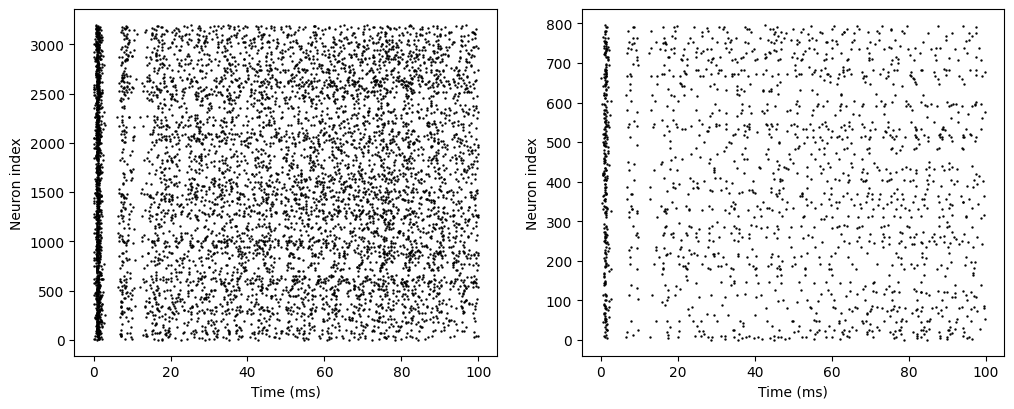

<module 'matplotlib.pyplot' from 'c:\\Users\\USER\\anaconda3\\envs\\AI_BCI\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.5))

ts = indices * bm.get_dt()
plt.subplot(121)
bp.visualize.raster_plot(ts, E_sps, show=False)
plt.subplot(122)
bp.visualize.raster_plot(ts, I_sps, show=True)